# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Исходя из тех задания, метрикой для измерения качества моделей является RMSE. Так же необходимо, чтобы ее значение было менее 2500 евро.

Признаки в датасете:

* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

Целевой признак:
* `Price` — цена (евро)

In [1]:
!pip install optuna

     |████████████████████████████████| 413 kB 1.2 MB/s eta 0:00:01


In [2]:
!pip install lightgbm

In [3]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform


from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.compose import make_column_transformer, ColumnTransformer

from sklearn.pipeline import make_pipeline, Pipeline

import optuna
import lightgbm as lgb

## Загрузка данных

В нашем распоряжении датасет с информацией рыночной стоимости автомобилей за определенный промежуток времени. Прежде чем начать обучение моделей машинного обучения, загрузим и выполним предобработку данных.

In [4]:
data = pd.read_csv('/datasets/autos.csv')

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

* в данных 15 признаков;
* есть пропущенные значения;
* есть признаки, которые не влияют на качество и предсказание модели.

Оставим сырые данные в переменной `data`. Сохраним сырые данные в новой переменной и в дальнейшем будем работать с ней.

In [7]:
autos = data.copy()

In [8]:
#переведем названия столбцов в нижний регистр
autos.columns = autos.columns.str.lower()

In [9]:
# удалим ненужные признаки
autos = autos.drop(['datecrawled',
                   'registrationmonth',
                   'numberofpictures',
                   'postalcode'],
                   axis=1)

In [10]:
#check
autos.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired,datecreated,lastseen
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24 00:00:00,2016-04-07 03:16:57
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24 00:00:00,2016-04-07 01:46:50
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14 00:00:00,2016-04-05 12:47:46
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17 00:00:00,2016-03-17 17:40:17
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31 00:00:00,2016-04-06 10:17:21


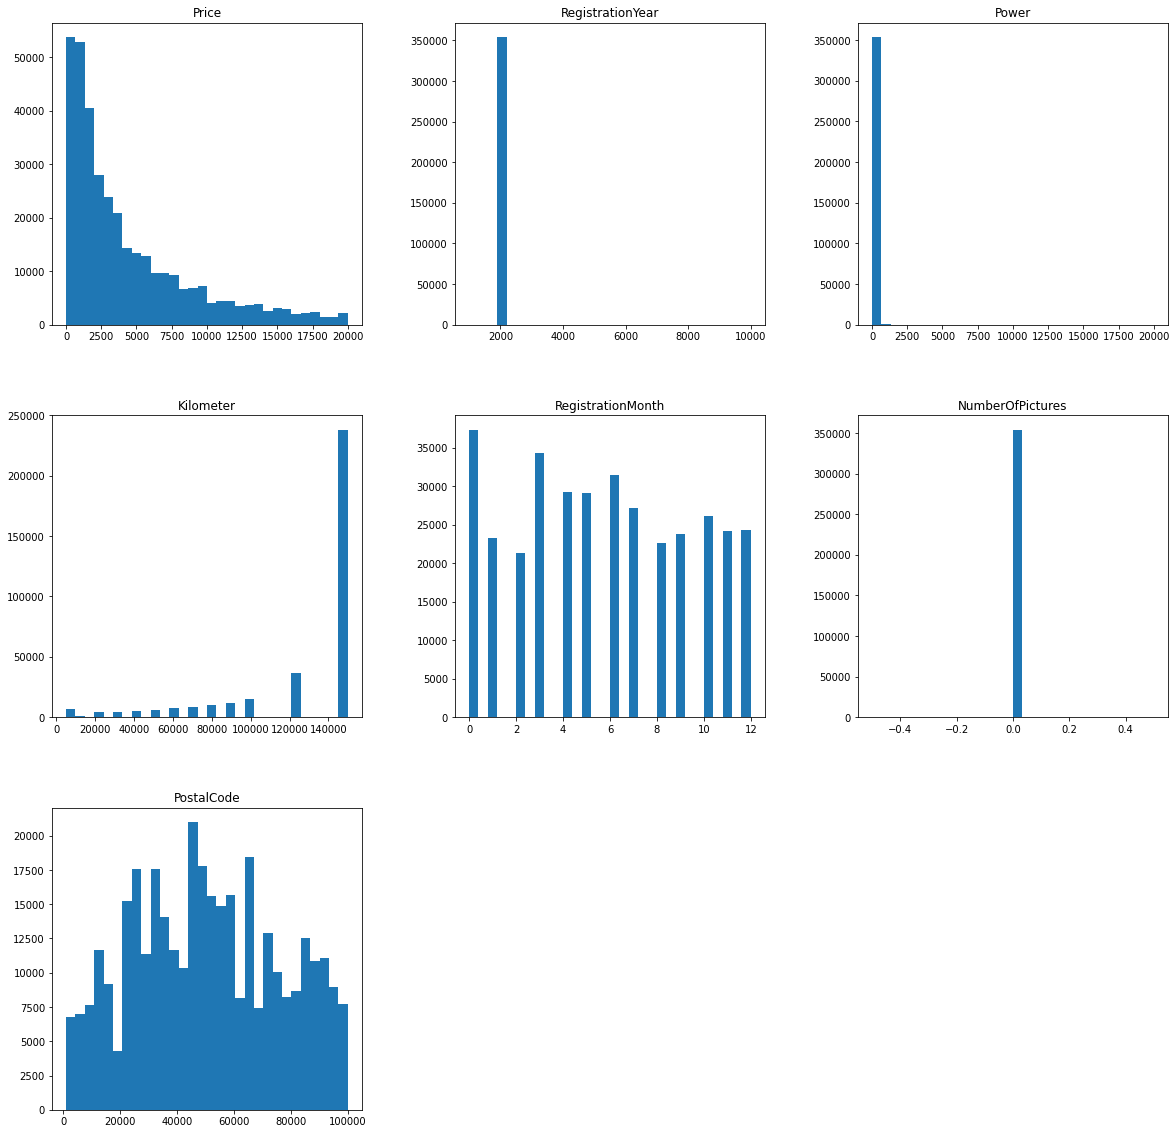

In [11]:
data.hist(bins=30, figsize=(20,20), grid=False);

* из распределения видно, что больше всего машин с ценой ниже 5000;
* скорее всего есть аномальные значения в колонке с годом регистрации и мощностью;
* большинство объявлений с машинами пробегом равным 150 тыс. км, скорее всего это порог пробега.

Далее попробуем заполнить пропущенные значения там, где это возможно.

### Пропущенные значения

Определим процент пропущенных значений в каждом из признаков.

In [12]:
autos_na = autos.isna().sum().sort_values(ascending=False)/len(autos) * 100
autos_na

repaired            20.079070
vehicletype         10.579368
fueltype             9.282697
gearbox              5.596709
model                5.560588
price                0.000000
registrationyear     0.000000
power                0.000000
kilometer            0.000000
brand                0.000000
datecreated          0.000000
lastseen             0.000000
dtype: float64

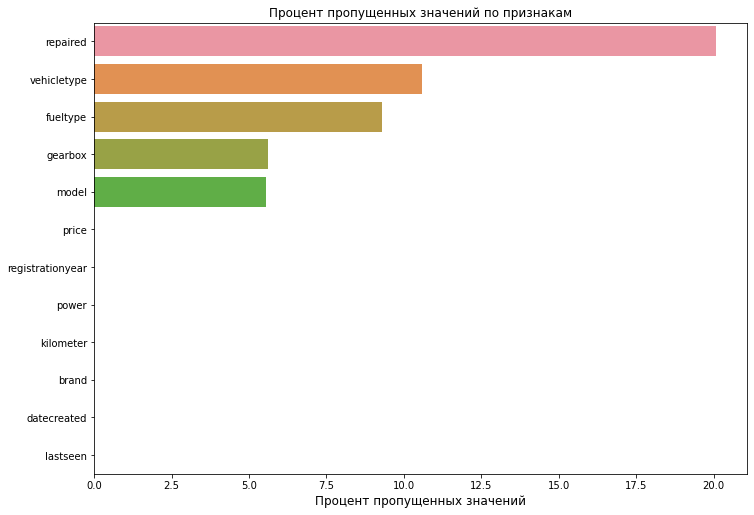

In [13]:
fig, axs = plt.subplots(figsize=(11.7, 8.3))
sns.barplot(y=autos_na.index, x=autos_na)

plt.xlabel('Процент пропущенных значений', fontsize=12);
plt.title('Процент пропущенных значений по признакам', fontsize=12);

* больше всего пропусков в признаке `repaired` - 20%;
* пропуски в признаке `model` восстановить не получится, так как нельзя определить модель автомобиля по другим признакам;
* `gearbox` - коробка передача зависит от комплектации автомобиля и может быть как ручной, так и автоматической;
* `fueltype` - как и с коробкой передач тип топлива может быть различной для одних и тех же автомобилях;
* `vehicletype` - тип кузова так же зависит от комплектации автомобиля и может быть различной, ее можно определить по полному названию модели автомобиля, но в данных названия неполные;
* `repaired` - пропуски можно заполнить если принимать во внимание, что чем больше пробег, тем больше шанс, что автомобиль ремонтировали.

Перед заполнением пропущенный значений, удалим объявления, где есть пропуски во всех пяти признаках.

In [14]:
before_fill = autos.shape[0]
print('Количество строк до удаления пропусков:', before_fill)

Количество строк до удаления пропусков: 354369


In [15]:
autos = autos.dropna(subset=['repaired', 'vehicletype', 'gearbox', 'model', 'fueltype'], how='all')
print('Количество строк после удаления строк с 5ю пропусками:', autos.shape[0])

Количество строк после удаления строк с 5ю пропусками: 352132


#### Признак Repaired

Сперва попробуем заполнить пропуски в признаке `repaired`.

In [16]:
# посмотрим на уникальные значения
autos['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

Категориальные признак, имеющий два значения и пропущенные значения. Природа пропусков многовероятно состои в том, что владельцы автомобилей забывали указать или намерено не заполняли. Как-либо заполнить достоверными сведениями невозможно, но и удалить большое количество данных не следует, поэтому создадим третью категорию и добавим в нее все пропущенные значения в этом признаке.

In [17]:
autos['repaired'] = autos['repaired'].fillna('missed')

#### признак model

Этот признак указывает на модель автомобиля, посмотрим на количество уникальных значений.

In [18]:
autos['model'].nunique()

250

Большое количество уникальных значений. Сгруппируем модели по брендам и посмотрим на распределение пропусков в моделях по брендам.

In [19]:
autos.groupby('brand')['model'].apply(lambda x: x.notnull().sum()).sort_values(ascending=False)

brand
volkswagen        73508
opel              38060
bmw               34979
mercedes_benz     30836
audi              28173
ford              24166
renault           17192
peugeot           10107
fiat               9141
seat               6672
skoda              5359
mazda              5263
smart              4978
citroen            4899
nissan             4734
toyota             4449
hyundai            3359
mini               3140
volvo              3101
mitsubishi         2862
honda              2662
kia                2352
suzuki             2186
alfa_romeo         2177
chevrolet          1644
chrysler           1350
dacia               878
daihatsu            767
subaru              718
porsche             716
jeep                651
land_rover          532
saab                510
daewoo              496
trabant             494
jaguar              491
lancia              448
rover               404
lada                210
sonstige_autos        0
Name: model, dtype: int64

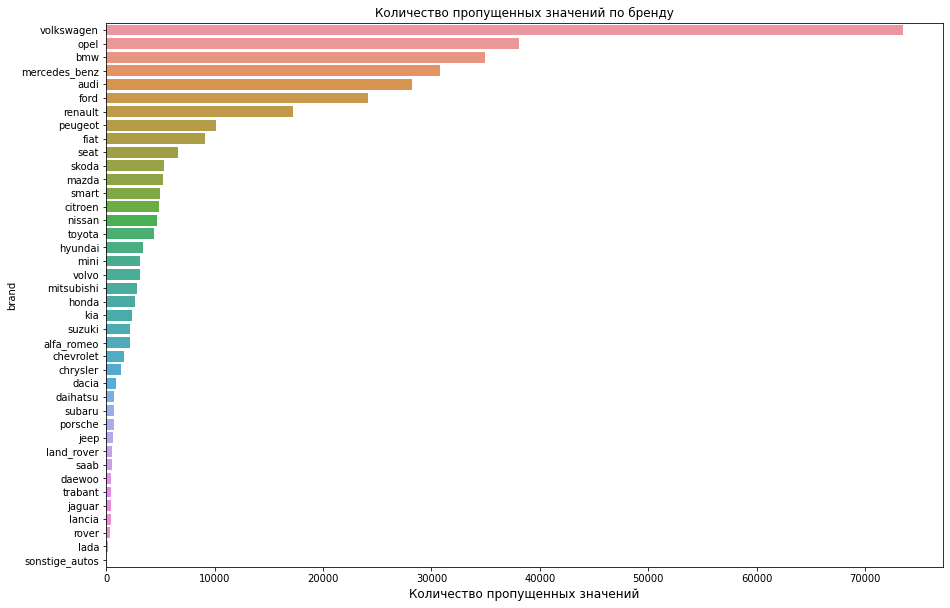

In [20]:
#построим график для наглядности
brand_model = autos.groupby('brand')['model'].apply(lambda x: x.notnull().sum()).sort_values(ascending=False)
# переведем в датафрейм
brand_model_df = brand_model.reset_index()
brand_model_df.columns = ['brand', 'count']

# построим график
fig, axs = plt.subplots(figsize=(15, 10))
sns.barplot(data=brand_model_df, x = 'count', y = 'brand', orient='h')

plt.xlabel('Количество пропущенных значений', fontsize=12);
plt.title('Количество пропущенных значений по бренду', fontsize=12);



Как заметно, пропусков больше всего в немецких брендах. Из сырых данных по значениям признака `PostalCode` ясно, что данные собранные из различных регионов Германии. Пользователи не указывали бренд, скорее всего, потому что модель довольна популярна.

Посмотрим в сырых данных на распределение автомобилей по регионам Германии. Первая цифра почтового индекса указывает на регион, поэтому будем разделять на регионы. Для этого оставим только первую цифру почтового индекса, которая указывает на область.

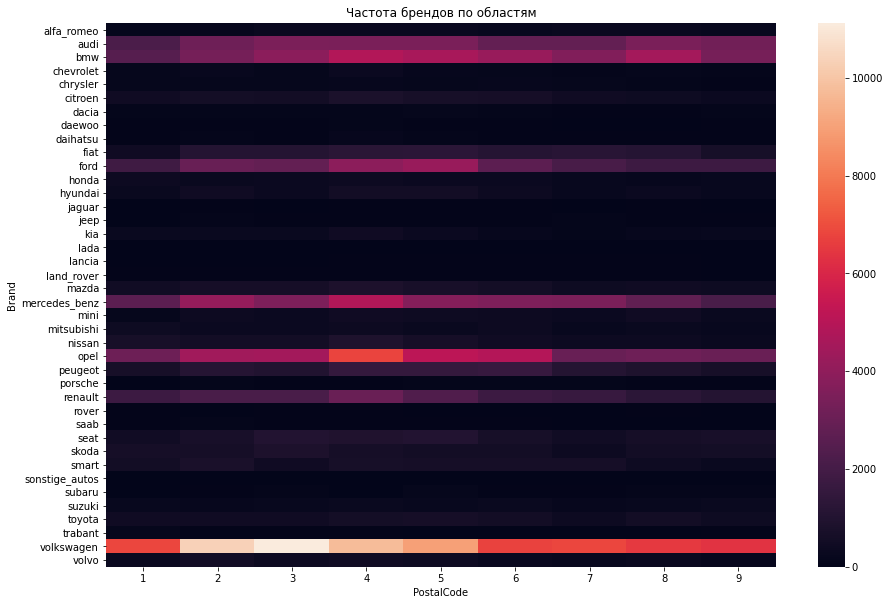

In [21]:
# оставим только первую цифру в почтовом индексе
data['PostalCode'] = data['PostalCode'].astype(str).str[:1].astype(int)

# сгруппируем данные по бренду, модели и почтовому индексу
model_region_popularity = data.groupby(['Brand', 'PostalCode']).count()['Model'].reset_index()
model_region_popularity = model_region_popularity.pivot_table(index='Brand', columns='PostalCode', values='Model')

# построим тепловую карту по частотности 
fig, axs = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(model_region_popularity);

plt.title('Частота брендов по областям', fontsize=12);


В целом, предпочтение отдается немецким брендам, но есть различия в областях. К примеру в 4 регион достаточно популярен Opel, но в 9 он не так популярен. Учитывая это, можно заполнить пропуски в моделях автомобилей в зависимости от региона объявления и бренда. Заполнять будем модой.

In [22]:
# сгруппируем по бренду и индексу
brand_postal = data.groupby(['Brand', 'PostalCode'])
# определим пропущено ли значение
all_na = brand_postal['Model'].transform(lambda x: x.isna().all())
# сгруппируем моды и заполним
data.loc[all_na, 'Model'] = data['Model'].mode()[0]
mode_by_group = brand_postal['Model'].transform(lambda x: x.mode()[0])
data['Model'] = data['Model'].fillna(mode_by_group)

In [23]:
# теперь соединим сырые данные с обработанными по индексу и заменим признак модели с заполненными пропусками
autos = autos.join(data["Model"]).drop(autos.columns[5], axis=1)

In [24]:
autos.columns = autos.columns.str.lower()

In [25]:
#check
autos.isna().sum()

price                   0
vehicletype         35253
registrationyear        0
gearbox             17596
power                   0
kilometer               0
fueltype            30658
brand                   0
repaired                0
datecreated             0
lastseen                0
model                   0
dtype: int64

#### Признак Vehicle type

Посмотрим на распределение признака по количествам предложений.

In [26]:
# напишем функцию для группировки и построения графика
def group_plot(data, col1, col2, title, xlabel, ylabel):
    group = data.groupby(col1)[col2].count()
    groupdf = group.reset_index().sort_values(by=col2)
    groupdf.columns = [col1, 'count']

    fig, axs = plt.subplots(figsize=(15, 10))
    ax = sns.barplot(data=groupdf, x='count', y=col1);
    
    plt.title(title, fontsize=12);
    plt.xlabel(xlabel, fontsize=12);
    plt.ylabel(ylabel, fontsize=12);
    


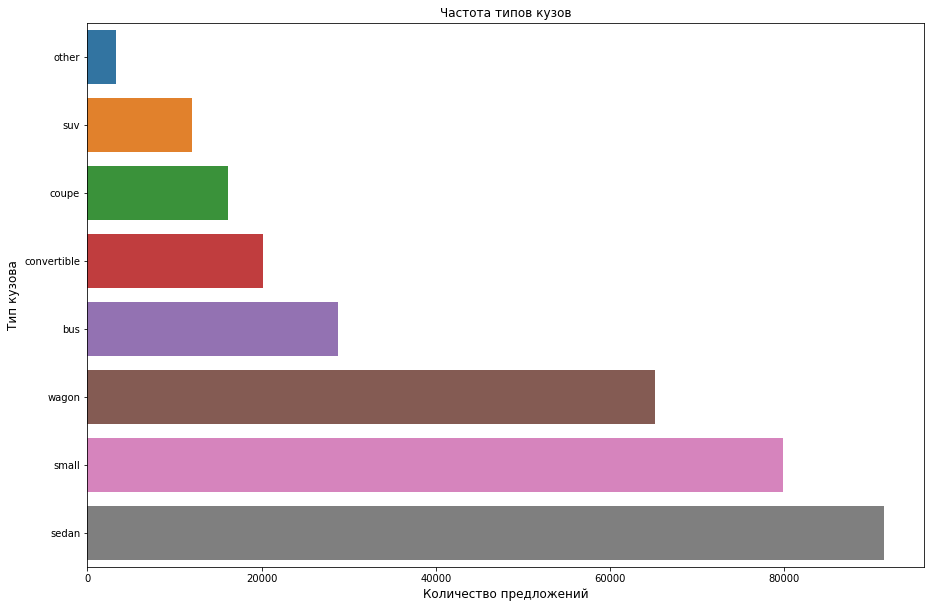

In [27]:
group_plot(autos, 'vehicletype', 'brand', 'Частота типов кузов', 'Количество предложений', 'Тип кузова')

Видно, что доминируют три типа кузова: sedan, small и wagon. 

Заполним пропуски модами по группировке бренда и модели.

In [28]:
# сгруппируем по бренду и индексу
brand_model_vtype = autos.groupby(['brand', 'model'])
# определим пропущено ли значение
all_na = brand_model_vtype['vehicletype'].transform(lambda x: x.isna().all())
# сгруппируем моды и заполним
autos.loc[all_na, 'vehicletype'] = autos['vehicletype'].mode()[0]
mode_by_group = brand_model_vtype['vehicletype'].transform(lambda x: x.mode()[0])
autos['vehicletype'] = autos['vehicletype'].fillna(mode_by_group)

In [29]:
#check
autos.isna().sum()

price                   0
vehicletype             0
registrationyear        0
gearbox             17596
power                   0
kilometer               0
fueltype            30658
brand                   0
repaired                0
datecreated             0
lastseen                0
model                   0
dtype: int64

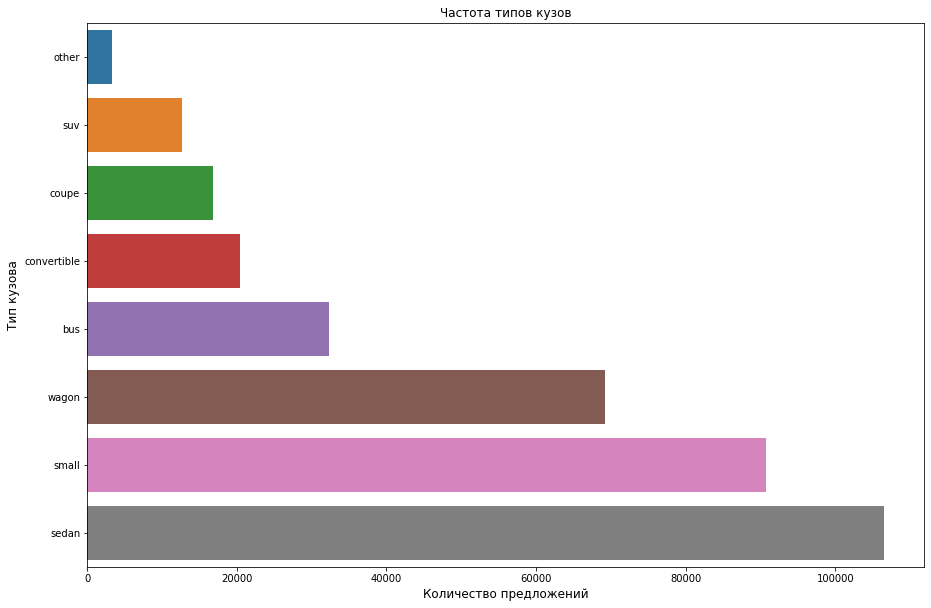

In [30]:
# проверим какое стало распределение
group_plot(autos, 'vehicletype', 'brand', 'Частота типов кузов', 'Количество предложений', 'Тип кузова')

Не изменилось.

#### Признак fueltype

Точно так же сгруппируем данные и посмотрим на распределение.

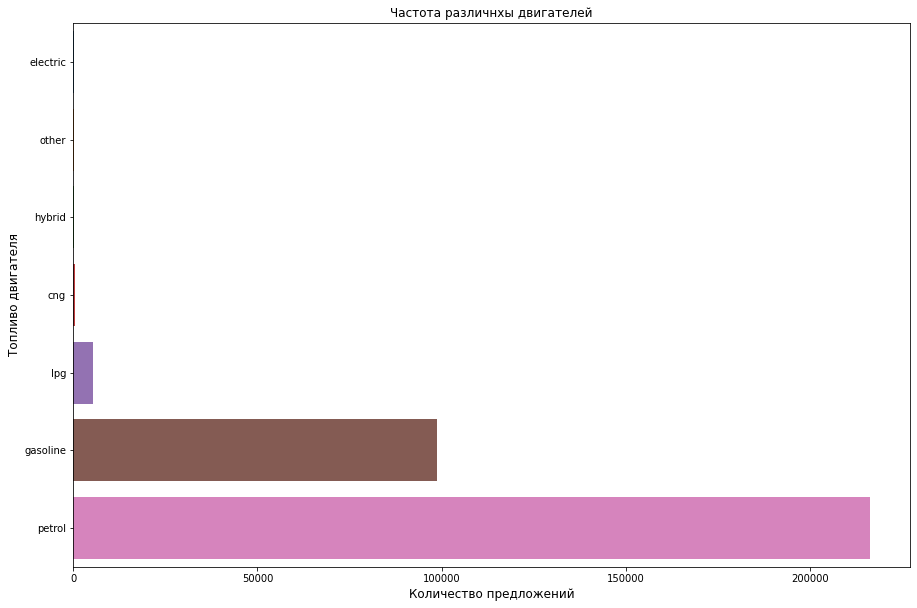

In [31]:
group_plot(autos, 'fueltype', 'brand', 'Частота различнхы двигателей', 'Количество предложений', 'Топливо двигателя')

Почти все предложения авто с двигателями, которые работают на бензине. Причем `gasoline` так же является бензином. Разница лишь в том, что gasoline термин используется в Америке, а petrol в Европе. Поэтому заменим названия gasoline.

In [32]:
autos['fueltype'] = autos['fueltype'].str.replace('gasoline','petrol')

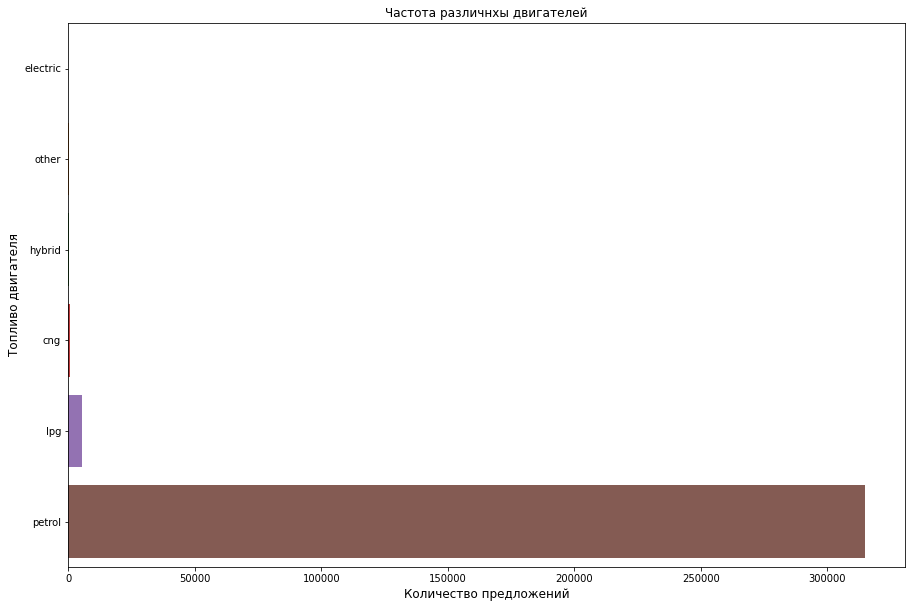

In [33]:
group_plot(autos, 'fueltype', 'brand', 'Частота различнхы двигателей', 'Количество предложений', 'Топливо двигателя')

Для чистоты так же заполним модой.

In [34]:
# сгруппируем данные
brand_model_fueltype = autos.groupby(['brand', 'model'])
# определим пропущено ли значение
all_na = brand_model_fueltype['fueltype'].transform(lambda x: x.isna().all())
# сгруппируем моды и заполним
autos.loc[all_na, 'fueltype'] = autos['fueltype'].mode()[0]
mode_by_group = brand_model_fueltype['fueltype'].transform(lambda x: x.mode()[0])
autos['fueltype'] = autos['fueltype'].fillna(mode_by_group)

In [35]:
#check
autos.isna().sum()

price                   0
vehicletype             0
registrationyear        0
gearbox             17596
power                   0
kilometer               0
fueltype                0
brand                   0
repaired                0
datecreated             0
lastseen                0
model                   0
dtype: int64

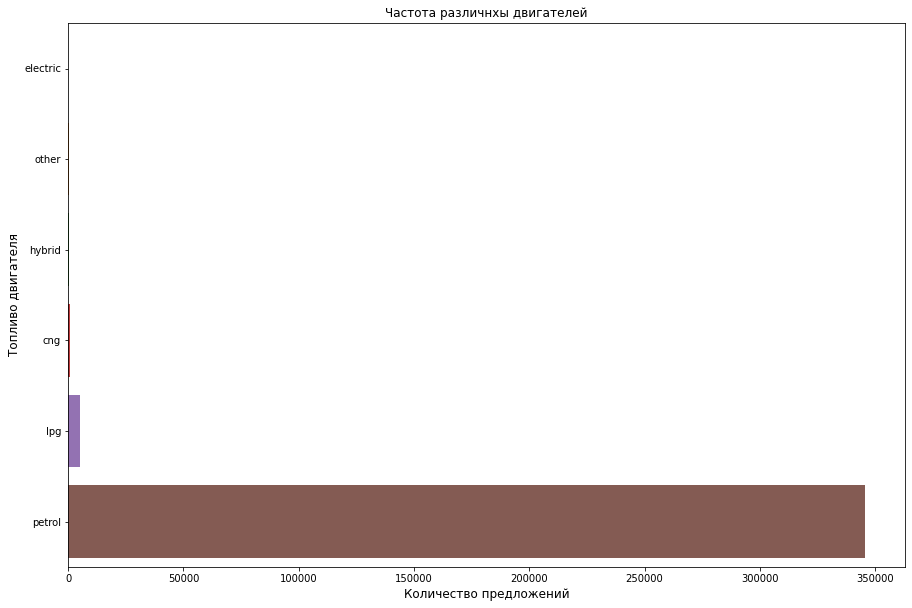

In [36]:
group_plot(autos, 'fueltype', 'brand', 'Частота различнхы двигателей', 'Количество предложений', 'Топливо двигателя')

Распределение не изменилось.

#### Признак gearbox

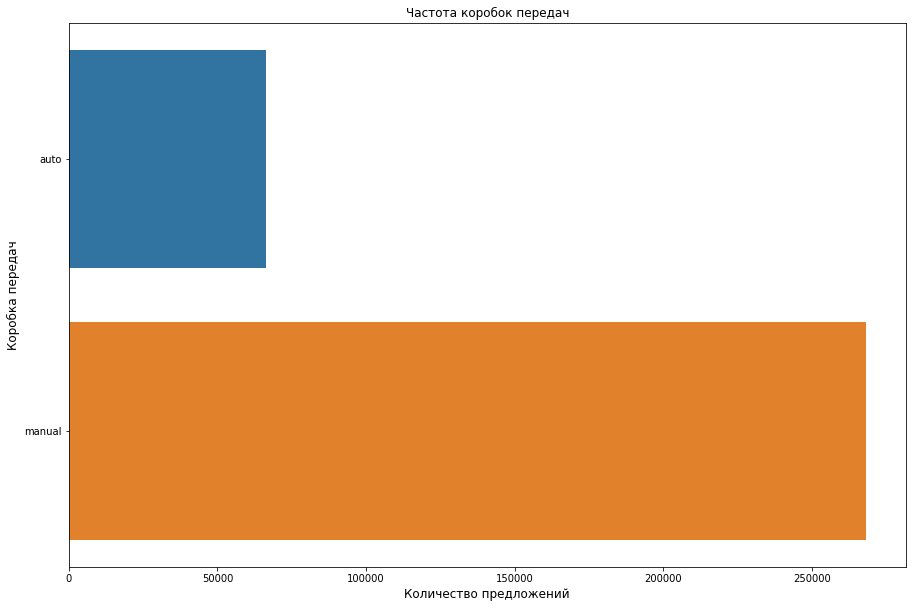

In [37]:
group_plot(autos, 'gearbox', 'brand', 'Частота коробок передач', 'Количество предложений', 'Коробка передач')

Больше всего встречается механическая коробка передач. За неимением лучшего способа, так же заполним модой в зависимости от бренда и модели.

In [38]:
# сгруппируем данные
brand_model_gbox = autos.groupby(['brand', 'model'])
# определим пропущено ли значение
all_na = brand_model_gbox['gearbox'].transform(lambda x: x.isna().all())
# сгруппируем моды и заполним
autos.loc[all_na, 'gearbox'] = autos['gearbox'].mode()[0]
mode_by_group = brand_model_gbox['gearbox'].transform(lambda x: x.mode()[0])
autos['gearbox'] = autos['gearbox'].fillna(mode_by_group)

In [39]:
#check
autos.isna().sum()

price               0
vehicletype         0
registrationyear    0
gearbox             0
power               0
kilometer           0
fueltype            0
brand               0
repaired            0
datecreated         0
lastseen            0
model               0
dtype: int64

Посмотрим на распределение после заполнения пропусков.

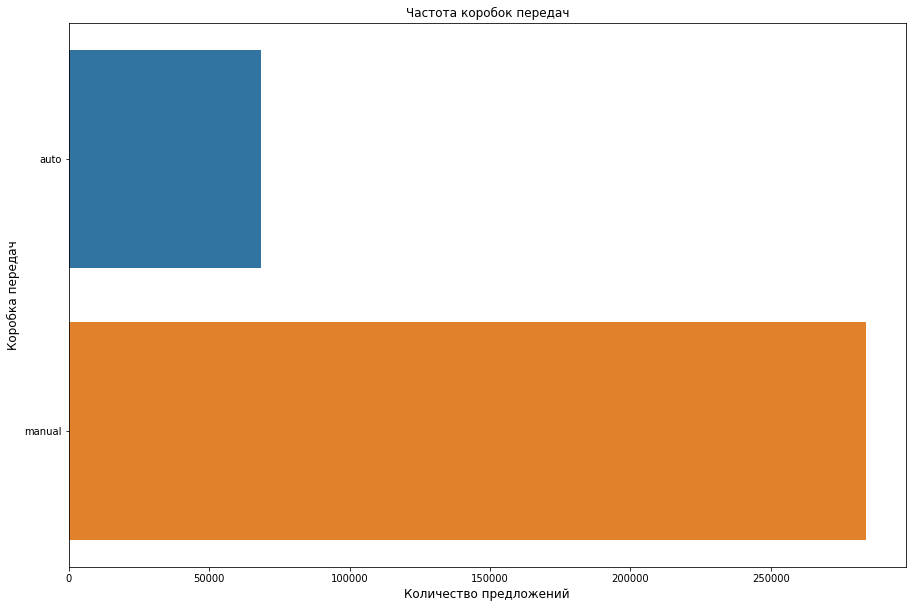

In [40]:
group_plot(autos, 'gearbox', 'brand', 'Частота коробок передач', 'Количество предложений', 'Коробка передач')

#### Вывод

В данных были пропуски в следующих признаках: `repaired`, `model`, `vehicle type`, `fueltype` и `gearbox`. 

1. В колонке `repaired` использовали заглушку, так как невозможно как-либо заполнить пропущенные значения. 
2. В колонке `model` заполнили по моде в зависимости от бренда и области объявления.
3. В колонках `vehicle type`, `fueltype` и `gearbox` заполняли модой в зависимости от модели и бренда автомобиля, так как это технические характеристики, которые напрямую зависят от них.

### Аномальные значения

In [41]:
autos.describe().T

,count,mean,std,min,25%,50%,75%,max
price,352132.0,4437.540570,4516.540446,0.0,1100.0,2750.0,6450.0,20000.0
registrationyear,352132.0,2003.871636,70.673430,1000.0,1999.0,2003.0,2008.0,9999.0
power,352132.0,110.720108,190.249667,0.0,69.0,105.0,143.0,20000.0
kilometer,352132.0,128438.071519,37562.896848,5000.0,125000.0,150000.0,150000.0,150000.0


* есть аномалии в цене (минимальное значение ноль);
* есть аномалии в регистрации (1910 год);
* есть аномалии в мощности (минимальное значение ноль);
* в километрах аномалий скорее всего нет.


#### Год регистрации транспортного средства

Максимальное значение в 9999 и минимальное в 1000 являются ошибочными. Ограничим максимальный год регистрации - максимальным годом выгрузки анкет.

In [42]:
pd.to_datetime(data['DateCrawled']).drop_duplicates().sort_values()

329497   2016-03-05 14:06:22
220583   2016-03-05 14:06:23
99885    2016-03-05 14:06:24
220604   2016-03-05 14:06:25
238727   2016-03-05 14:06:26
                 ...        
204218   2016-04-07 14:36:53
53739    2016-04-07 14:36:54
301030   2016-04-07 14:36:55
339649   2016-04-07 14:36:56
90713    2016-04-07 14:36:58
Name: DateCrawled, Length: 271174, dtype: datetime64[ns]

Последняя анкета была выгружена 04.07.2016. Ограничим год регистрации 2016 годом.

In [43]:
autos = autos.query('registrationyear < 2017')

Минимальное значение регистрации ограничим 1950 годом, иначе не понять графики, далее скорректируем.

In [44]:
autos = autos.query('registrationyear > 1949')

Посмотрим на количество объявлений по годам регистрации.

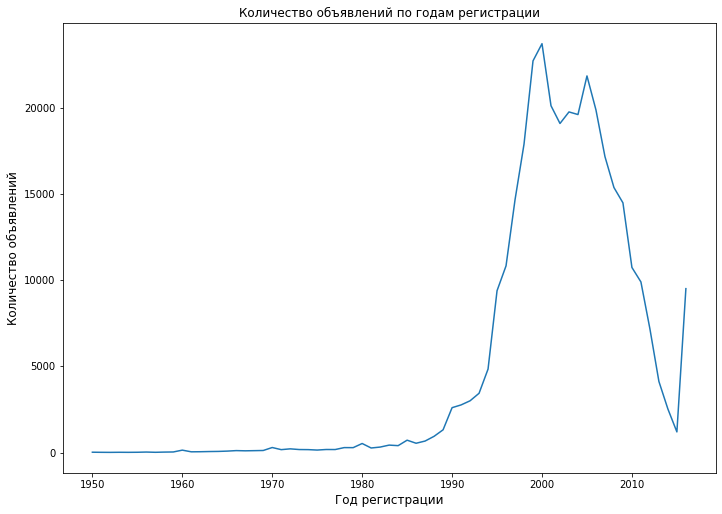

In [45]:
# группировка данных
autos_per_year = autos.groupby('registrationyear')['price'].count()
# построение графика
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.lineplot(data=autos_per_year);
plt.ylabel('Количество объявлений', fontsize=12);
plt.xlabel('Год регистрации', fontsize=12);
plt.title('Количество объявлений по годам регистрации', fontsize=12);


Из графика видно, что очень мало объявлений машин с регистрацией примерно ранее 1990 года. Это либо старые машины, либо антиквариатные ретро автомобили, поэтому цена на машины будет сильно отличаться. Данных для обучения модели таких автомобилей слишком мало, следовательно, необходимо ограничить год регистрации.

Построим диаграмму размаха и определим нижнюю границу.

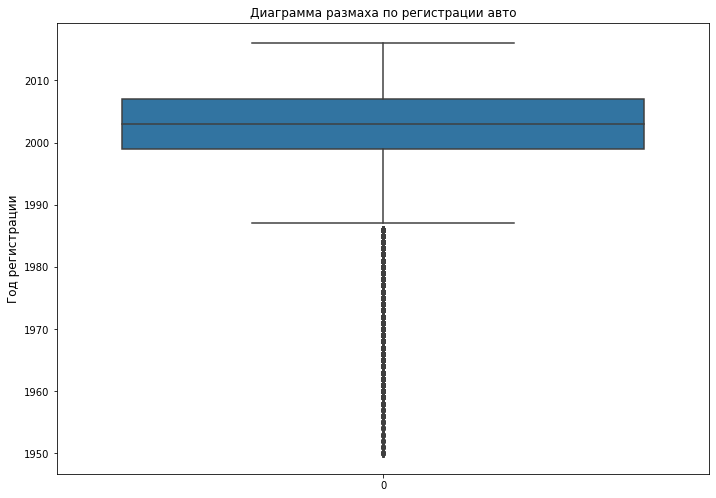

In [46]:
fig = plt.subplots(figsize=(11.7, 8.3))
ax = sns.boxplot(data=autos['registrationyear'].values)
plt.title('Диаграмма размаха по регистрации авто', fontsize=12)
plt.ylabel('Год регистрации',fontsize=12);
plt.show()


На этом графике уверенно определить границу. Велика вероятность ошибки. Для более наглядных результатов сделаем дополнительный график, где будет отображена только нижняя часть диаграммы размахов. Для этого ограничим значение по оси Y.

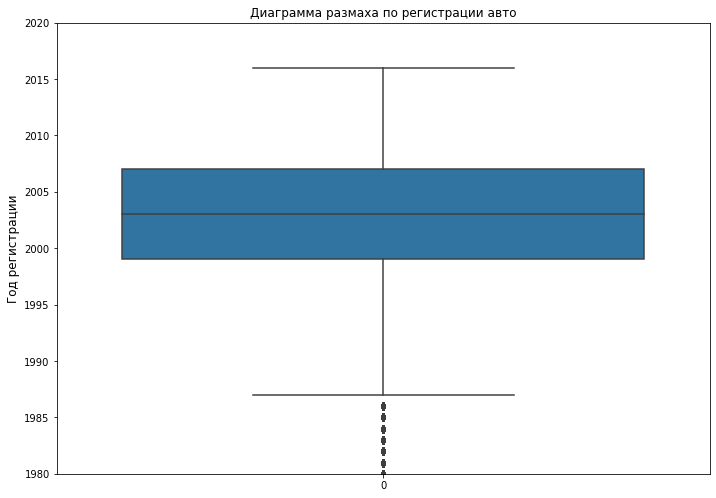

In [47]:
fig = plt.subplots(figsize=(11.7, 8.3))
ax = sns.boxplot(data=autos['registrationyear'].values)
ax.set(ylim=(1980, 2020))
plt.title('Диаграмма размаха по регистрации авто', fontsize=12)
plt.ylabel('Год регистрации',fontsize=12);
plt.show()

Посмотрим сколько объявлений о продаже автомобилей с регистрацией ранее 1986 года.

In [48]:
print('Количество объявлений с регистрацией ранее 1986 года:', autos.query('registrationyear < 1986').shape[0])
print('Количество объявлений:', autos.shape[0])


Количество объявлений с регистрацией ранее 1986 года: 5757
Количество объявлений: 337593


Доля таких объявлений от общего количества очень мала (~1.2%), поэтому избавимся от таких объявлений.

In [49]:
autos = autos.query('registrationyear > 1985')

In [50]:
#check
autos['registrationyear'].describe()

count    331836.000000
mean       2003.003764
std           5.814811
min        1986.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registrationyear, dtype: float64

#### Мощность автомобиля

Посмотрим еще раз на распределение, предварительно удалив нулевые значения.

In [51]:
autos = autos.query('power > 0')

In [52]:
autos['power'].describe()

count    298861.000000
mean        124.592801
std         192.523263
min           1.000000
25%          77.000000
50%         112.000000
75%         150.000000
max       20000.000000
Name: power, dtype: float64

Максимальное значение мощности - явная ошибка при в воде и является аномальным значением. Самая мощная грузовая машина имеет мощность 4000 л.с.

Посмотрим на диаграмму размаха и определим границы.

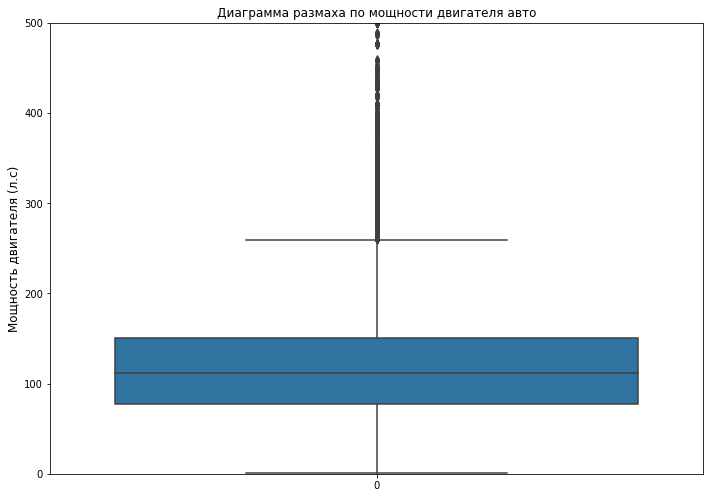

In [53]:
fig = plt.subplots(figsize=(11.7, 8.3))
ax = sns.boxplot(data=autos['power'].values)
plt.title('Диаграмма размаха по мощности двигателя авто', fontsize=12)
plt.ylabel('Мощность двигателя (л.с)',fontsize=12);
ax.set(ylim=(0, 500))
plt.show()

К примеру, мощность двигателя автомобиля вольксфаген гольф может быть от 45 до 250 л.с. На одном из сайтов по продажам автомобилей из 117000 объявлений только 46 предложений о продаже авто с двигателем мощностью до 30 лошадиных сил. Это или старые или раритеные, поэтому ограничимся минимальной мощностью в 40 л.с. 

In [54]:
autos.query('power < 41').shape[0]

1101

Таких объявлений всего 536.

Верхней же границей зададимся в 450 л.с. Это грузовые или спортивные автомобили.

In [55]:
autos.query('power > 450').shape[0]

486

Таких объявлений 255.

In [56]:
autos = autos.query("power > 39 & power < 451")

In [57]:
#check
autos['power'].describe()

count    297554.000000
mean        120.844848
std          52.849195
min          40.000000
25%          77.000000
50%         113.000000
75%         150.000000
max         450.000000
Name: power, dtype: float64

#### Цена

Предварительно удалим нулевые значения.

In [58]:
autos = autos.query('price > 0')

In [59]:
autos['price'].describe()

count    291423.000000
mean       4829.554517
std        4596.322455
min           1.000000
25%        1300.000000
50%        3150.000000
75%        6990.000000
max       20000.000000
Name: price, dtype: float64

Есть минимальное значение с ценой 1 евро. До 25% объявлений объявления с ценой до 1550 евро. Посмотрим на объявления с ценой ниже 500 евро и с ценой более 18000 евро.

In [60]:
display(autos.query('price < 500'))
display(autos.query('price > 18000'))

,price,vehicletype,registrationyear,gearbox,power,kilometer,fueltype,brand,repaired,datecreated,lastseen,model
16,300,small,2016,manual,60,150000,petrol,volkswagen,missed,2016-04-01 00:00:00,2016-04-01 12:46:46,polo
23,450,small,1997,manual,50,150000,petrol,seat,no,2016-03-12 00:00:00,2016-03-21 01:46:11,arosa
35,350,sedan,2016,manual,75,150000,petrol,volkswagen,no,2016-03-08 00:00:00,2016-03-08 09:44:50,golf
59,1,suv,1994,manual,286,150000,petrol,sonstige_autos,missed,2016-03-29 00:00:00,2016-04-06 01:44:38,golf
60,200,coupe,1995,manual,102,150000,petrol,bmw,missed,2016-03-26 00:00:00,2016-04-01 20:46:51,3er
...,...,...,...,...,...,...,...,...,...,...,...,...
354293,480,sedan,1996,manual,136,150000,petrol,mercedes_benz,missed,2016-04-02 00:00:00,2016-04-06 13:17:50,c_klasse
354296,450,small,1997,manual,102,150000,petrol,bmw,no,2016-03-30 00:00:00,2016-04-01 14:46:24,3er
354297,400,wagon,1996,manual,150,150000,petrol,audi,missed,2016-03-11 00:00:00,2016-03-11 13:43:10,a4
354309,99,small,1999,manual,60,150000,petrol,seat,yes,2016-03-09 00:00:00,2016-04-06 22:15:32,arosa


,price,vehicletype,registrationyear,gearbox,power,kilometer,fueltype,brand,repaired,datecreated,lastseen,model
1,18300,coupe,2011,manual,190,125000,petrol,audi,yes,2016-03-24 00:00:00,2016-04-07 01:46:50,a4
172,19750,convertible,2006,manual,305,50000,petrol,ford,no,2016-03-07 00:00:00,2016-03-12 20:18:29,mustang
204,18400,wagon,2011,auto,313,150000,petrol,bmw,no,2016-03-31 00:00:00,2016-03-31 13:44:44,5er
282,18700,coupe,2009,auto,213,80000,petrol,ford,no,2016-03-06 00:00:00,2016-04-06 05:44:39,mustang
337,18880,bus,2014,manual,116,20000,petrol,mazda,no,2016-03-20 00:00:00,2016-04-06 08:46:43,5_reihe
...,...,...,...,...,...,...,...,...,...,...,...,...
353590,19950,wagon,2009,manual,265,125000,petrol,audi,no,2016-03-14 00:00:00,2016-03-20 21:45:10,other
353686,18429,sedan,2010,manual,272,125000,petrol,bmw,no,2016-03-10 00:00:00,2016-04-01 21:48:04,3er
353927,18500,sedan,2009,auto,190,150000,petrol,audi,no,2016-03-30 00:00:00,2016-03-30 18:44:53,a4
354178,19990,small,2014,auto,185,10000,petrol,audi,no,2016-03-13 00:00:00,2016-04-07 03:17:51,a1


Можно заметить, что машины ценой менее 500 евро чаще с большим пробегом и более старой регистрацией. Так же есть машины, которые продавались буквально за пару дней, а есть за месяц. Так как цену назначает сам владелец автомобиля, то он может указать неправдоподобную. Модель в дальнейшем будет хуже предсказывать, поэтому попробуем ограничить время продажи автомобиля.

Учитывая, что колонка `datecreated` обозначает дату создания объявления, а `lastseen` дату последней активности пользователя, вычислим разницу между этими двумя колонками. Допускается, что `lastseen` это примерная дата продажи.

In [61]:
# переведем в тип данных datetime
autos[['datecreated', 'lastseen']] = autos[['datecreated', 'lastseen']].apply(pd.to_datetime)

In [62]:
# создадим новую колонку с разницей в днях
autos['daysold'] = (autos['lastseen'] - autos['datecreated']).dt.days

In [63]:
# check
autos.head()

,price,vehicletype,registrationyear,gearbox,power,kilometer,fueltype,brand,repaired,datecreated,lastseen,model,daysold
1,18300,coupe,2011,manual,190,125000,petrol,audi,yes,2016-03-24,2016-04-07 01:46:50,a4,14
2,9800,suv,2004,auto,163,125000,petrol,jeep,missed,2016-03-14,2016-04-05 12:47:46,grand,22
3,1500,small,2001,manual,75,150000,petrol,volkswagen,no,2016-03-17,2016-03-17 17:40:17,golf,0
4,3600,small,2008,manual,69,90000,petrol,skoda,no,2016-03-31,2016-04-06 10:17:21,fabia,6
5,650,sedan,1995,manual,102,150000,petrol,bmw,yes,2016-04-04,2016-04-06 19:17:07,3er,2


In [64]:
autos['daysold'].unique()

array([ 14,  22,   0,   6,   2,   4,  11,  17,  16,  13,   9,  19,   1,
        27,  12,   8,   3,  51,  21,  15,  20,   5,  28,   7,  23,  18,
        24,  10,  29,  55,  30,  26,  33,  31,  32,  25,  37,  41, 384,
        35,  36,  48,  45,  40, 136,  42,  52,  63,  61,  34,  49, 122,
        53,  47,  60,  38,  39,  50,  44,  46,  59,  88,  43, 141,  74,
        58,  94, 193, 146,  91,  54, 133,  56,  62, 108, 244,  68,  65,
        96, 135,  70,  80,  89, 125,  83, 150,  81,  69,  72, 239,  95,
        64,  78,  57,  98, 109, 110,  66, 149,  67, 121,  73,  71, 209,
        99])

Из названия сервиса делаю вывод, что он ориентирован на российский рынок. Среднее время продажи автомобилей с пробегом на территории РФ 32 дня. Ограничим объявления и удалим те, которые продавались более 90 дней.

In [65]:
autos.query('daysold > 90')

,price,vehicletype,registrationyear,gearbox,power,kilometer,fueltype,brand,repaired,datecreated,lastseen,model,daysold
4001,6000,bus,1995,auto,200,150000,petrol,chevrolet,no,2015-03-20,2016-04-07 03:45:01,other,384
9972,3490,sedan,2006,manual,88,150000,petrol,renault,no,2015-11-02,2016-03-17 15:46:57,clio,136
29712,6950,sedan,2004,auto,150,100000,petrol,audi,no,2015-12-06,2016-04-06 14:16:09,a3,122
60168,5999,sedan,1997,auto,197,150000,petrol,mercedes_benz,no,2015-11-17,2016-04-06 05:46:03,c_klasse,141
75418,750,wagon,1993,manual,90,150000,petrol,audi,no,2016-01-02,2016-04-05 19:17:02,80,94
75598,600,small,2005,manual,54,150000,petrol,volkswagen,yes,2015-09-04,2016-03-15 14:16:58,polo,193
75684,5400,small,2009,manual,44,40000,petrol,lancia,no,2015-11-12,2016-04-06 03:16:57,ypsilon,146
76459,7500,sedan,2002,auto,333,150000,lpg,bmw,no,2015-12-27,2016-03-27 22:15:37,7er,91
77378,7999,sedan,2013,manual,75,30000,petrol,seat,no,2015-11-24,2016-04-05 22:47:33,mii,133
85505,900,sedan,1997,auto,115,150000,petrol,subaru,no,2015-12-05,2016-03-22 23:16:25,impreza,108


Таких объявлений немного.

In [66]:
autos = autos.query('daysold < 91')

Далее ограничим нижнюю границу цены. Для этого построим диаграмму размаха.

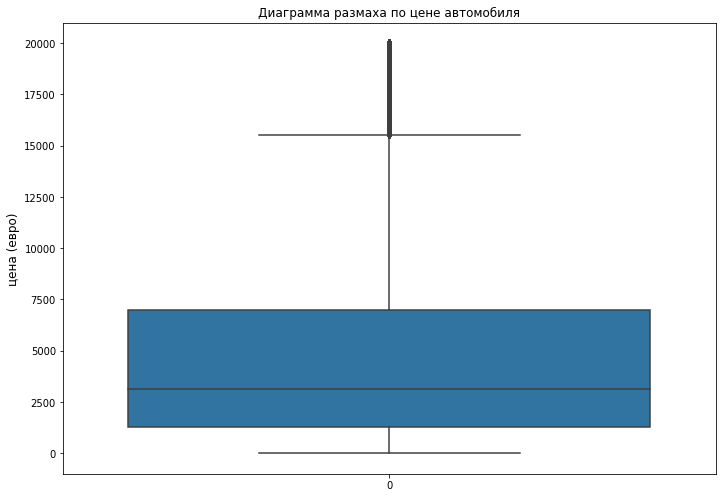

In [67]:
fig = plt.subplots(figsize=(11.7, 8.3))
ax = sns.boxplot(data=autos['price'].values)
plt.title('Диаграмма размаха по цене автомобиля', fontsize=12)
plt.ylabel('цена (евро)',fontsize=12);
plt.show()

Видно, что цена в 1 евро не считается выбросом в диаграмме размаха.

В другом сервисе с более 100000 объявлений есть только одно ценой 300 евро, при этом машина в плохом состоянии. Учитывая это, ограничим нижнюю границу в 500 евро.

In [68]:
autos.query('price < 500')

,price,vehicletype,registrationyear,gearbox,power,kilometer,fueltype,brand,repaired,datecreated,lastseen,model,daysold
16,300,small,2016,manual,60,150000,petrol,volkswagen,missed,2016-04-01,2016-04-01 12:46:46,polo,0
23,450,small,1997,manual,50,150000,petrol,seat,no,2016-03-12,2016-03-21 01:46:11,arosa,9
35,350,sedan,2016,manual,75,150000,petrol,volkswagen,no,2016-03-08,2016-03-08 09:44:50,golf,0
59,1,suv,1994,manual,286,150000,petrol,sonstige_autos,missed,2016-03-29,2016-04-06 01:44:38,golf,8
60,200,coupe,1995,manual,102,150000,petrol,bmw,missed,2016-03-26,2016-04-01 20:46:51,3er,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354293,480,sedan,1996,manual,136,150000,petrol,mercedes_benz,missed,2016-04-02,2016-04-06 13:17:50,c_klasse,4
354296,450,small,1997,manual,102,150000,petrol,bmw,no,2016-03-30,2016-04-01 14:46:24,3er,2
354297,400,wagon,1996,manual,150,150000,petrol,audi,missed,2016-03-11,2016-03-11 13:43:10,a4,0
354309,99,small,1999,manual,60,150000,petrol,seat,yes,2016-03-09,2016-04-06 22:15:32,arosa,28


Таких объявлений почти 8000 и почти все с пробегом более 150000 км. Удалим их.

In [69]:
autos = autos.query('price > 499')

In [70]:
#check
autos['price'].describe()

count    274610.000000
mean       5106.960912
std        4591.128542
min         500.000000
25%        1500.000000
50%        3500.000000
75%        7300.000000
max       20000.000000
Name: price, dtype: float64

### Вывод

В предобработке данных избавились от пропущенных значений и аномалий. Было решено удалить пропуски, чтобы не исказить данные, так как нет способа достоверно заполнить их.

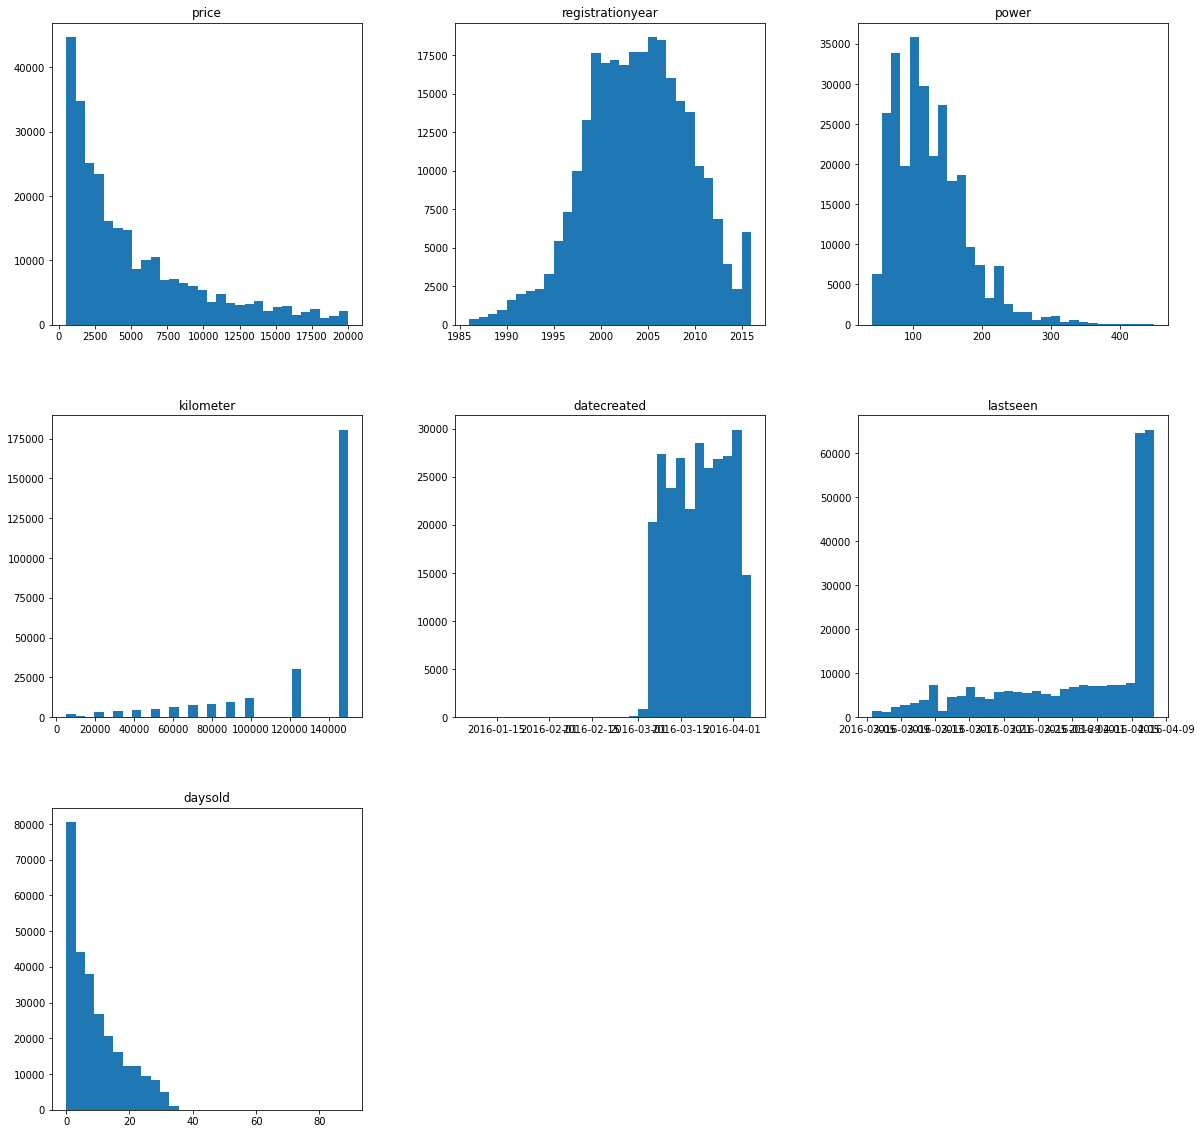

In [71]:
autos.hist(bins=30, figsize=(20,20), grid=False);

В дальнейшем нам не понадобятся колонки `datecreated` и `lastseen`.

In [72]:
autos = autos.drop(['datecreated', 'lastseen'], axis=1)

Посмотрим на корреляцию признаков с целевым признаком.

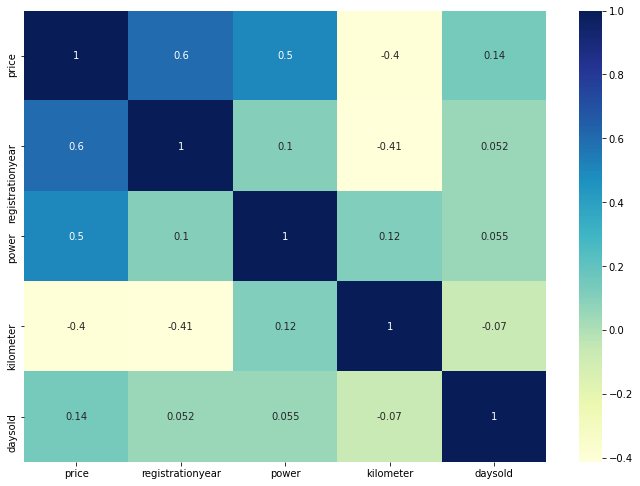

In [73]:
fig = plt.subplots(figsize=(11.7, 8.3))
ax = sns.heatmap(autos.corr(), cmap="YlGnBu", annot=True);
plt.show()

* средняя положительная корреляция цены с годом регистрации;
* средняя положительная корреляция цены с мощностью двигателя;
* средняя отрицательная корреляция цены с пробегом.

Так же новая колонка `daysold` в дальнейшем не понадобится.

In [74]:
autos = autos.drop('daysold', axis=1)

In [75]:
#check
autos.head()

,price,vehicletype,registrationyear,gearbox,power,kilometer,fueltype,brand,repaired,model
1,18300,coupe,2011,manual,190,125000,petrol,audi,yes,a4
2,9800,suv,2004,auto,163,125000,petrol,jeep,missed,grand
3,1500,small,2001,manual,75,150000,petrol,volkswagen,no,golf
4,3600,small,2008,manual,69,90000,petrol,skoda,no,fabia
5,650,sedan,1995,manual,102,150000,petrol,bmw,yes,3er


Далее разделим данные на обучающую и тестовую.

## Подготовка выборок для машинного обучения

Для начала разделим выборки, а далее закодируем их. Для линейных моделей используем метод OHE (one hot encoder), для остальных моделей OE (порядковое кодирование).

In [76]:
# разделим данные на выборки
X_train, X_test, y_train, y_test = train_test_split(autos.drop('price', axis=1), 
                                                    autos['price'], 
                                                    test_size=0.33, 
                                                    random_state=42)

### Кодирование выборок

Для моделей ridge и linear regression используем OHE кодирование и StandartScaler. 

Для Decision tree и gradient boosting OrdinalEncoding.

In [77]:
# выделим название столбцов с категориальными и численными признаками в отдельные переменные
cat_features = X_train.select_dtypes(include='object').columns.to_list()
num_features = X_train.select_dtypes(exclude='object').columns.to_list()

#### Для линейных моделей

In [78]:
# создадим отдельную выборку для линейный моделей
X_train_ohe= X_train.copy()
X_test_ohe = X_test.copy()

In [79]:
%%time
# создадим энкодер и обучим на тренировочной выборке
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error' , sparse=False)
encoder_ohe.fit(X_train_ohe[cat_features])
#добавляем закодированные данные
X_train_ohe[encoder_ohe.get_feature_names()] = encoder_ohe.transform(X_train_ohe[cat_features])

# удаляем незакодированные
X_train_ohe = X_train_ohe.drop(cat_features, axis=1)

CPU times: user 16.3 s, sys: 1.59 s, total: 17.9 s
Wall time: 17.9 s


In [80]:
X_train_ohe.head()

,registrationyear,power,kilometer,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_wagon,...,x5_wrangler,x5_x_reihe,x5_x_trail,x5_x_type,x5_xc_reihe,x5_yaris,x5_yeti,x5_ypsilon,x5_z_reihe,x5_zafira
131027,2007,140,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29473,2003,204,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
235699,2010,120,60000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
289325,2006,90,125000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76347,2003,116,150000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
# отмасштабируем данные
# создаем scaler
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
X_train_ohe[num_features] = scaler.fit_transform(X_train_ohe[num_features])

X_train_ohe.head()

,registrationyear,power,kilometer,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_wagon,...,x5_wrangler,x5_x_reihe,x5_x_trail,x5_x_type,x5_xc_reihe,x5_yaris,x5_yeti,x5_ypsilon,x5_z_reihe,x5_zafira
131027,0.633727,0.314875,0.597138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29473,-0.086265,1.525392,0.597138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
235699,1.173721,-0.063412,-1.867600,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
289325,0.453729,-0.630841,-0.087511,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76347,-0.086265,-0.139069,0.597138,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Для других моделей

In [82]:
X_train_oe = X_train.copy()

In [83]:
encoder_oe = OrdinalEncoder()
encoder_oe.fit(X_train_oe[cat_features])

OrdinalEncoder()

In [84]:
X_train_oe[cat_features] = encoder_oe.transform(X_train_oe[cat_features])

In [85]:
#check
X_train_oe.head()

,vehicletype,registrationyear,gearbox,power,kilometer,fueltype,brand,repaired,model
131027,0.0,2007,0.0,140,150000,5.0,38.0,1.0,219.0
29473,0.0,2003,0.0,204,150000,3.0,5.0,1.0,166.0
235699,4.0,2010,1.0,120,60000,5.0,1.0,1.0,29.0
289325,4.0,2006,1.0,90,125000,5.0,21.0,1.0,165.0
76347,2.0,2003,1.0,116,150000,5.0,2.0,1.0,11.0


Признаки закодированы и отмасштабированы.

## Обучение моделей

В рамках исследования будут применяться следующие модели: Ridge, DecisionTree,  LinearRegression и GradientBoosting. Метрикой является RMSE.

### Ridge

In [86]:
%%time
ridge = Ridge(random_state=42)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_ridge = {'alpha': np.arange(0, 0.21, 0.01),}

gs_ridge = GridSearchCV(
    ridge, 
    param_grid=param_grid_ridge, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

gs_ridge.fit(X_train_ohe, y_train)

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {gs_ridge.best_score_ * -1}')

# лучшие гиперпараметры
print(f'best_params: {gs_ridge.best_params_}')

best_score: 2409.0813714620695
best_params: {'alpha': 0.2}
CPU times: user 1min 43s, sys: 54.3 s, total: 2min 37s
Wall time: 2min 37s


In [87]:
ridge_fit_time = gs_ridge.cv_results_['mean_fit_time'].mean()
ridge_pred_time = gs_ridge.cv_results_['mean_score_time'].mean()
print(f'Время для обучения: {ridge_fit_time}')
print(f'Время для предсказаний: {ridge_pred_time}')

Время для обучения: 1.3244679337456113
Время для предсказаний: 0.159775177637736


### Linear Regression

In [88]:
%%time
linr = LinearRegression()
param_lin = { }
gs_linr = GridSearchCV(linr, param_grid=param_lin, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
gs_linr.fit(X_train_ohe, y_train)

CPU times: user 46.2 s, sys: 17 s, total: 1min 3s
Wall time: 1min 3s


GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1, param_grid={},
             scoring='neg_root_mean_squared_error')

In [89]:
# лучшее значение RMSE на кросс-валидации
print(f'best_score: {gs_linr.best_score_ * -1}')

best_score: 2409.1902787823374


In [90]:
lin_fit_time = gs_linr.cv_results_['mean_fit_time'].mean()
lin_pred_time = gs_linr.cv_results_['mean_score_time'].mean()
print(f'Время для обучения: {lin_fit_time}')
print(f'Время для предсказаний: {lin_pred_time}')

Время для обучения: 10.258919668197631
Время для предсказаний: 0.09922666549682617


### Решающие деревья

In [91]:
%%time
def dtreg_objective(trial):
    
    
    params = {
        'max_depth': [trial.suggest_int('max_depth', 2, 10)],
         'min_samples_split': [trial.suggest_int('min_samples_split', 2, 5)],
         'min_samples_leaf': [trial.suggest_int('min_samples_leaf', 1, 5)]
    }
    
    clf = DecisionTreeRegressor(random_state=42)
    grid_search = GridSearchCV(clf, params, cv=3, scoring='neg_root_mean_squared_error')
    grid_search.fit(X_train_oe, y_train)
    trial.set_user_attr('cv_results', grid_search.cv_results_)
    return grid_search.best_score_
    
dtreg_study = optuna.create_study(direction='maximize')
dtreg_study.optimize(dtreg_objective, n_trials=10)
dtreg_study.best_trial.user_attrs['cv_results']
dt_rmse = dtreg_study.best_trial.user_attrs['cv_results']['mean_test_score'].round(2)
dt_fit_time = dtreg_study.best_trial.user_attrs['cv_results']['mean_fit_time'].round(2)
dt_score_time = dtreg_study.best_trial.user_attrs['cv_results']['mean_score_time'].round(2)
print('Лучшие гиперпараметры:', dtreg_study.best_params)
print('Лучшее значение метрики:', -dt_rmse)
print('Время обучения:', dt_fit_time)
print('Время предсказания:', dt_score_time)

[I 2024-02-12 15:01:59,443] A new study created in memory with name: no-name-e0e134f9-23fd-4dc7-b4dd-e3a37bf5c829
[I 2024-02-12 15:02:00,251] Trial 0 finished with value: -2024.9814051549984 and parameters: {'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: -2024.9814051549984.
[I 2024-02-12 15:02:01,215] Trial 1 finished with value: -1917.2924484543364 and parameters: {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: -1917.2924484543364.
[I 2024-02-12 15:02:01,999] Trial 2 finished with value: -2024.949432689662 and parameters: {'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 1 with value: -1917.2924484543364.
[I 2024-02-12 15:02:02,684] Trial 3 finished with value: -2101.420102941532 and parameters: {'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 1 with value: -1917.2924484543364.
[I 2024-02-12 15:02:03,301] Trial 4 finished with value: -2

Лучшие гиперпараметры: {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1}
Лучшее значение метрики: [1917.29]
Время обучения: [0.21]
Время предсказания: [0.01]
CPU times: user 7.34 s, sys: 67.9 ms, total: 7.41 s
Wall time: 7.45 s


### Градиентный бустинг

Гиперпараметры подберем с помощью RandomSearchCV из библиотеки scikitlearn. Категориальные признаки не требуют дополнительного кодирования данных.

    LightGBM offers good accuracy with integer-encoded categorical features. LightGBM applies Fisher (1958) to find the   optimal split over categories as described here. This often performs better than one-hot encoding.

In [92]:
X_train_lgb = X_train.copy()

In [93]:
X_train_lgb[cat_features] = X_train_lgb[cat_features].astype('category')

In [94]:
%%time
params = {
    'num_leaves': [4, 5],
    'max_depth': [1, 3, 5, 7],
    'n_estimators': [50, 100],
}

grid = GridSearchCV(lgb.LGBMRegressor(random_state=42), params, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)
grid.fit(X_train_lgb, y_train)

lgbm_tuned = grid.best_estimator_

grid.best_params_

CPU times: user 1min 37s, sys: 0 ns, total: 1min 37s
Wall time: 1min 38s


{'max_depth': 5, 'n_estimators': 100, 'num_leaves': 5}

In [95]:
lgb_fit_time = grid.cv_results_['mean_fit_time'].mean()
lgb_pred_time = grid.cv_results_['mean_score_time'].mean()
lgb_rmse = grid.best_score_ * -1

## Анализ моделей

Было протестировано 4 алгоритма машинного обучения:

* линейная регрессия;
* ridge;
* решающее дерево;
* градиентный бустинг.



In [96]:
data_metrics = {'Classifier': ['Ridge', 'LinearRegression', 'Decision Tree Regressor', 'Lightgbm'],
                 'RMSE': [-gs_ridge.best_score_, -gs_linr.best_score_, -dt_rmse, lgb_rmse],
                'Время обучения': [ridge_fit_time, lin_fit_time, dt_fit_time, lgb_fit_time],
                'Время предсказания': [ridge_pred_time, lin_pred_time, dt_score_time, lgb_pred_time]
    }
df = pd.DataFrame(data=data_metrics).round(2)
df

,Classifier,RMSE,Время обучения,Время предсказания
0,Ridge,2409.081371,1.324468,0.159775
1,LinearRegression,2409.190279,10.25892,0.099227
2,Decision Tree Regressor,[1917.29],[0.21],[0.01]
3,Lightgbm,1745.375231,1.759012,0.230567


Лучший результат метрики показала модель градиентного бустинга. Самой быстрой моделью по времени обучении и по времени предсказания является Decision tree. Было принято решение использовать модель Lightgbm из-за лучшего значения метрики, различия по времени незначительны. В дополнении модель LGBMRegressor не требует кодирования данных.

### Тест лучшей модели

In [97]:
X_test_lgb = X_test.copy()

In [98]:
X_test_lgb[cat_features] = X_test_lgb[cat_features].astype('category')

In [99]:
%%time
y_pred = grid.predict(X_test_lgb)

CPU times: user 436 ms, sys: 0 ns, total: 436 ms
Wall time: 375 ms


In [100]:
lgb_rse_pred = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE на тестовой выборке:', lgb_rse_pred)

RMSE на тестовой выборке: 1739.7728318545187


## Общий вывод

В ходе исследования были проделаны следующие шаги:

1. Были загруженны и исследованны данные по продажам поддержанных автомобилей. В ходе обработки данных избавились заполнили пропущенные значения. От аномальных значений избавились, ограничив данные из здравого смысла и распределения значений.

2. Данные делились на обучающую и тестовую. Для линейной модели использовался метод One Hot Encoder для перевода категориальных переменных в численные, а так же масштабировались численные переменные. Для модели Decision Tree использовалось только кодирование категориальных переменных. Для модели LGBMRegressor кодирование данных не использовалось.

3. Тестировались 4 модели машинного обучения:

* Ridge.
* Linear regression.
* Decision tree.
* LGBMRegressor


Учитывая требования заказчика, предлагается модель градиентного бустинга с `RMSE` равным 1739. При более подробной оптимизации модели метрику можно улучшить.